# 1. 이해하기

## 1.1 환경 변수 설정

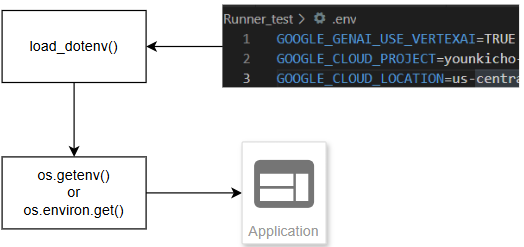

### 1.1.1 load_dotenv()

ADK(Agent Development Kit)에서 `load_dotenv()` 함수는 일반적으로 Python 스크립트 상단 부근에서 호출됩니다. 이 함수의 주요 목적은 **`.env` 파일에서 환경 변수를 로드**하는 것입니다.

`load_dotenv`를 사용하여 `.env` 파일에 환경 변수를 저장하는 것은 ADK 설정의 **모범 사례** 중 하나로 언급됩니다. 특히, **자격 증명(credentials)을 안전하게 저장**하는 데 유용합니다.

ADK 에이전트나 도구는 종종 **LLM(Large Language Model) 서비스와의 통신에 필요한 인증 정보**나 기타 구성 설정을 환경 변수에서 로드해야 합니다. 예를 들어, Gemini API 키나 Vertex AI 관련 설정 (`GOOGLE_GENAI_USE_VERTEXAI`, `GOOGLE_CLOUD_PROJECT`, `GOOGLE_CLOUD_LOCATION`), 또는 OpenAI 및 Anthropic 모델 사용을 위한 API 키 등이 `.env` 파일에 저장될 수 있습니다.

`.env` 파일은 일반적으로 에이전트 프로젝트의 동일한 폴더에 생성됩니다. `load_dotenv()`를 호출하면, 이 파일에 정의된 `KEY=VALUE` 형식의 변수들이 현재 실행 환경의 환경 변수로 로드되어 ADK 애플리케이션 내에서 접근 가능하게 됩니다.

만약 유효한 인증 자격 증명이 환경 변수에 제대로 설정되지 않으면, LLM 서비스가 에이전트의 요청을 거부할 수 있으며, 결과적으로 에이전트가 의도한 기능을 수행할 수 없게 됩니다. 따라서 ADK 에이전트가 외부 서비스와 상호작용하려면 `load_dotenv`를 통해 필요한 환경 변수를 미리 로드하는 과정이 중요합니다.

### 1.1.2 os.getenv

`os.getenv`는 파이썬의 **`os` 모듈**에 포함된 함수로, 현재 실행 중인 **시스템의 환경 변수 값을 읽어오는 역할**을 합니다.

ADK (Agent Development Kit) 개발에서 `os.getenv` 또는 이와 유사한 `os.environ.get()` 함수를 사용하는 주된 이유는 다음과 같습니다.

1.  **설정 및 자격 증명 관리**: ADK 에이전트는 LLM 모델, 외부 서비스 (예: API, MCP 서버, 아티팩트 서비스, 메모리 서비스), 또는 클라우드 환경 설정 등과 상호작용해야 하는 경우가 많습니다. 이때 필요한 **API 키, 클라우드 프로젝트 ID, 지역 정보** 등은 코드 내에 직접 하드코딩하는 대신 환경 변수에 저장하는 것이 **보안적으로 안전하고 유연**합니다. `os.getenv`를 사용하면 코드 실행 시점에 이러한 환경 변수 값을 안전하게 읽어와 애플리케이션에 적용할 수 있습니다. 예를 들어, Vertex AI 사용 설정 여부, GCP 프로젝트 ID, GCP 위치 정보 등을 환경 변수에서 가져올 수 있습니다.

2.  **`.env` 파일과 함께 사용**: `load_dotenv()` 함수가 `.env` 파일에 정의된 `KEY=VALUE` 형태의 변수들을 읽어서 파이썬 스크립트의 환경 변수(정확히는 `os.environ`)로 로드하면, 이제 코드 내에서 `os.getenv('KEY')` 또는 `os.environ.get('KEY')`를 호출하여 해당 값을 가져올 수 있게 됩니다. 이것이 ADK 프로젝트 구조에서 `.env` 파일을 사용하는 모범 사례와 `load_dotenv()` 호출 및 환경 변수 접근이 함께 나타나는 이유입니다.

3.  **구성의 유연성**: 환경 변수를 사용하면 코드 수정 없이 환경 변수 값만 변경하여 에이전트의 설정을 쉽게 바꿀 수 있습니다. 예를 들어, 개발 환경에서는 로컬 설정을 사용하고, 배포 환경에서는 클라우드 환경 변수를 사용하도록 구성할 수 있습니다. `os.environ.get("PORT", 8080)`와 같이 환경 변수가 설정되지 않았을 경우 사용할 기본값을 지정하는 것도 가능합니다.

요약하자면, `os.getenv`는 파이썬에서 **환경 변수를 읽는 표준적인 방법**이며, ADK에서는 주로 **보안 자격 증명 및 다양한 구성 설정을 코드 외부에서 관리**하기 위해 `.env` 파일 로딩 (`load_dotenv`)과 함께 사용됩니다. 필요한 인증 정보가 환경 변수에 제대로 설정되지 않으면, 에이전트가 외부 서비스와의 통신에 실패하여 기능을 제대로 수행할 수 없게 됩니다.

## 1.2 Session Service

### 1.2.1 주요 역할

ADK(Agent Development Kit)에서 **`SessionService`**는 에이전트와의 **대화 상태를 관리**하는 핵심 구성 요소입니다. 사용자와 에이전트 시스템 간의 **단일하고 지속적인 상호 작용(대화 스레드)**을 나타내는 **`Session` 객체**의 전체 수명 주기를 관리합니다.

`SessionService`의 주요 역할은 다음과 같습니다  :

*   **새 대화 시작:** 사용자가 상호 작용을 시작할 때 새로운 `Session` 객체를 생성합니다  .
*   **기존 대화 재개:** 에이전트가 중단된 부분부터 다시 시작할 수 있도록 특정 `Session` 객체를 ID를 사용하여 검색합니다.
*   **진행 상황 저장:** 새로운 상호 작용(`Event` 객체)을 세션의 기록에 추가합니다. 이는 세션의 **`state`**가 업데이트되는 메커니즘이기도 합니다.
*   **대화 목록 조회:** 특정 사용자와 애플리케이션에 대한 활성 세션 스레드를 찾습니다.
*   **정리:** 대화가 종료되거나 더 이상 필요하지 않을 때 `Session` 객체 및 관련 데이터를 삭제합니다.

`SessionService`는 대화 기록(`events`)과 해당 특정 상호 작용에만 관련된 임시 데이터(`state`)를 포함하는 `Session` 객체를 관리합니다. 에이전트의 작업 메모리 역할을 하며 변수 및 특정 상호 작용과 관련된 기타 데이터를 저장합니다.

### 1.2.2 종류

ADK는 다양한 요구사항에 맞춰 여러 가지 `SessionService` 구현체를 제공합니다. 주요 구현체는 다음과 같습니다.

1.  **`InMemorySessionService`**
    *   **특징:** 모든 세션 데이터를 애플리케이션의 **메모리에 직접 저장**합니다.
    *   **지속성:** **데이터가 지속되지 않습니다**. 애플리케이션이 재시작되면 모든 대화 데이터가 손실됩니다.
    *   **요구 사항:** 추가적인 설정이 필요 없습니다  .
    *   **가장 적합한 용도:** 빠른 테스트       로컬 개발     예제 코드                               간단한 애플리케이션 또는 장기적인 지속성이 필요하지 않은 시나리오    .
    *   **참고:** 이 구현체에서는 데이터가 일시적(Ephemeral)입니다.

2.  **`DatabaseSessionService`**
    *   **특징:** 관계형 데이터베이스(예: PostgreSQL   MySQL   SQLite)에 연결하여 세션 데이터를 **지속적으로 저장**합니다. 데이터는 테이블에 저장됩니다.
    *   **지속성:** **데이터가 지속됩니다**  . 애플리케이션 재시작 후에도 데이터가 유지됩니다.
    *   **요구 사항:** 구성된 데이터베이스가 필요합니다.
    *   **가장 적합한 용도:** 직접 관리하는 안정적이고 지속적인 저장소가 필요한 애플리케이션.

3.  **`VertexAiSessionService`**
    *   **특징:** Google Cloud의 Vertex AI 인프라를 API 호출을 통해 사용하여 세션을 관리합니다.
    *   **지속성:** **데이터가 지속됩니다**  . Google Cloud에 의해 안정적이고 확장 가능하게 관리됩니다.
    *   **요구 사항:** Google Cloud 프로젝트   적절한 권한   필요한 SDK(`pip install google-adk[vertexai]`)   Reasoning Engine 리소스 이름/ID가 필요합니다.
    *   **가장 적합한 용도:** Google Cloud에 배포된 확장 가능한 프로덕션 애플리케이션   특히 다른 Vertex AI 기능과 통합될 때 유용합니다. ADK 에이전트를 Vertex AI Agent Engine에 배포하면 기본적으로 이 클라우드 기반 관리형 세션 서비스가 사용됩니다  .

4.  **사용자 정의 `SessionService` 구현**
    *   개발자는 `SessionService` 추상 클래스를 확장하여 자체 데이터베이스(예: Firestore 또는 MongoDB)를 사용한 사용자 정의 세션 서비스 구현체를 만들 수 있습니다      .
    *   **주의:** 사용자 정의 인메모리 세션 서비스를 사용하는 경우   에이전트를 Vertex AI Agent Engine에 배포할 때 세션이 동기화되지 않을 수 있습니다. 배포된 환경에서 세션 간 상태를 동기화할 수 있는 경우에만 사용자 정의 데이터베이스를 사용하는 것을 권장합니다.

### 1.2.3 결론

`SessionService`는 `session.state` 키에 `app:`   `user:`   `temp:`와 같은 접두사를 사용하여 상태의 범위(애플리케이션 전체   사용자별   세션별   임시)를 관리하며   이는 특히 지속성 있는 서비스에서 중요합니다            .

요약하면   ADK의 `SessionService`는 에이전트가 대화 컨텍스트(`Session`   `state`   `events`)를 관리할 수 있도록 하는 핵심 서비스이며   **`InMemorySessionService`**(개발/테스트용)   **`DatabaseSessionService`**(자체 관리 지속성용)   **`VertexAiSessionService`**(클라우드 관리 확장성용) 등의 다양한 구현체를 제공하여 애플리케이션의 요구사항에 맞는 저장 방식을 선택할 수 있도록 합니다      .

## 1.3 Runner

### 1.3.1 주요 기능 및 역할

**Runner**는 Google의 **Agent Development Kit (ADK)**의 핵심 구성 요소 중 하나로, **에이전트 실행을 오케스트레이션**하는 역할을 합니다. 단일 사용자 쿼리에 대한 **메인 진입점 및 오케스트레이터**입니다.

Runner의 주요 기능 및 역할은 다음과 같습니다.

*   **실행 오케스트레이션**: Runner는 에이전트 실행 루프를 오케스트레이션하는 메인 엔진입니다. 사용자의 쿼리를 받아 에이전트의 정의(지침, 모델, 도구 포함) 및 세션 컨텍스트와 함께 처리 과정을 관리합니다.
*   **이벤트 루프 관리**: 전체 이벤트 루프를 관리하며, 에이전트 실행 로직에서 생성된 이벤트들을 수신하고 처리합니다.
*   **LLM 및 도구 호출 관리**: 에이전트 로직을 기반으로 대규모 언어 모델(LLM)과 도구 호출을 관리합니다. Runner는 LiteLlm과 같은 모델 래퍼를 통해 LLM으로 요청을 전달할 수 있습니다.
*   **세션 및 상태 관리 연동**: SessionService를 통해 세션 상태를 관리하고 대화 기록 및 상태를 저장합니다. 새로운 쿼리나 에이전트가 생성한 이벤트를 세션 이벤트 기록에 추가하고 세션 서비스 또는 기타 서비스를 통해 상태나 아티팩트(artifact) 변경 사항을 커밋합니다.
*   **이벤트 생성 및 전달**: 상호작용 프로세스를 나타내는 이벤트들을 생성하고 상위 시스템(예: 사용자 인터페이스)으로 전달합니다.

### 1.3.2 사용법

**Runner 설정 및 사용**:

*   Runner는 실행할 에이전트 인스턴스, 애플리케이션 이름(`app_name`), 그리고 SessionService 인스턴스를 필수적으로 받아 초기화됩니다. 필요에 따라 ArtifactService도 추가할 수 있습니다.
*   Runner는 `run_async` 메서드를 통해 실행됩니다. 이 메서드는 사용자 ID, 세션 ID, 그리고 새로운 메시지(쿼리)를 인자로 받습니다.
*   `run_async` 호출은 이벤트들을 비동기적으로 생성하는 제너레이터(generator)를 반환하며, 개발자는 이 이벤트를 순회하며 에이전트의 진행 상황이나 결과를 처리할 수 있습니다.
*   ADK는 Runner를 직접 사용하는 코드 방식 외에도 CLI 도구(`adk run`)나 웹 UI(`adk web`)를 통해 에이전트와 상호작용할 수 있는 방법을 제공하며, 이들 또한 내부적으로 Runner를 활용합니다.

### 1.3.3 결론

Runner는 ADK 프레임워크에서 에이전트의 두뇌 역할을 하는 LLM, 외부와의 상호작용을 위한 도구, 그리고 대화 이력 및 상태를 관리하는 세션 서비스를 연결하여 에이전트가 작업을 수행하는 전체 과정을 조율하는 핵심 엔진입니다.

## 1.4 Runner 만들기

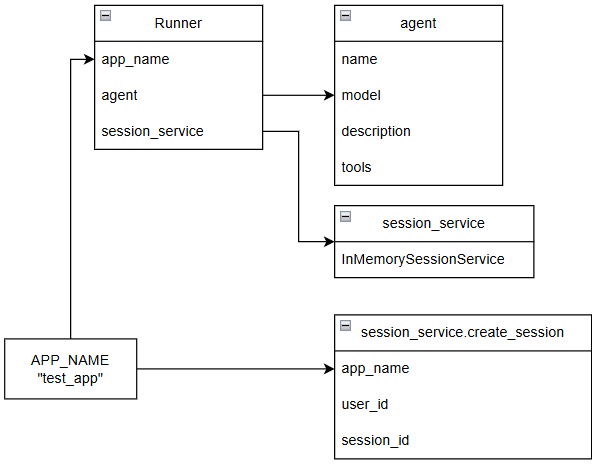

## 1.5 실행

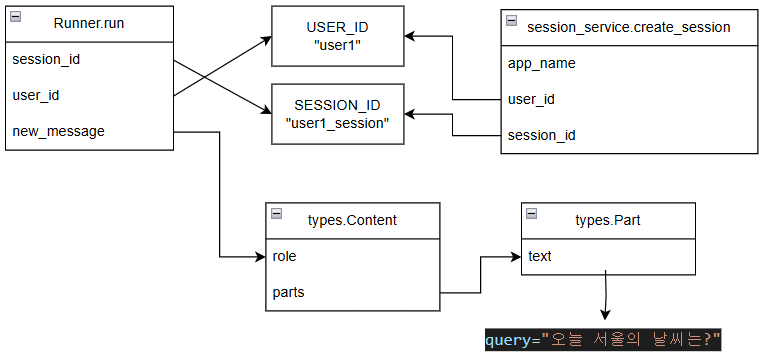

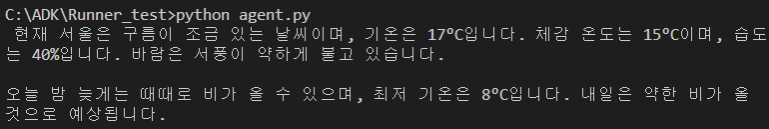

# 2. Code

In [ ]:
from google.adk.agents import Agent
from google.adk.tools import google_search
from google.adk.runners import Runner
from google.adk.sessions import InMemorySessionService
from google.genai import types

import os
from dotenv import load_dotenv


# main이 실행 전 동작해야 하는 내용
load_dotenv()
os.getenv("GOOGLE_CLOUD_PROJECT")
os.getenv("GOOGLE_CLOUD_LOCATION")
os.getenv("GOOGLE_GENAI_USE_VERTEXAI", "1")

AGENT_NAME="runner_agent"
MODEL="gemini-2.0-flash"
APP_NAME="test_app"
USER_ID="user1"
SESSION_ID=USER_ID+"_session"

def get_runner(agent):
    session_service = InMemorySessionService()
    session_service.create_session(
        app_name=APP_NAME,
        user_id=USER_ID,
        session_id=SESSION_ID
    )
    return Runner(
        app_name=APP_NAME,
        agent=agent,
        session_service=session_service
    )

if __name__=="__main__":
    runner_agent = Agent(
    name=AGENT_NAME,
    model=MODEL,
    description="구글 사이트에서 필요한 정보를 검색",
    tools=[google_search]
    )

    runner = get_runner(runner_agent)

    query="오늘 서울의 날씨는?"
    content = types.Content(
        role='user',
        parts=[types.Part(text=query)]
    )


    events = runner.run(
        session_id = SESSION_ID,
        user_id=USER_ID,
        new_message=content
    )

    for e in events:
        if e.is_final_response():
            final_response = e.content.parts[0].text
            print(final_response)